In [1]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../data/combinedData.csv')
target = pd.read_csv('../data/combinedTarget.csv')

data = data.merge(target, how='left',on=['Provider','Set'])
data.drop(columns = ['Unnamed: 0_x','Unnamed: 0_y'], inplace=True)

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,13,14,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Warmup Question 5: From Which Providers Do the Duplicated Claims Come From?
- An easier type of frauds is to submit duplicated claims using stolen patient IDs.
- While multiple claims with identical information are not always fraudulent, the prevalence of
these duplicated records would signal potential fraud activities. 
- Consider the various diagnosis codes, procedure codes, admit diagnosis codes as the key features, please identify
the duplicated claims in the inpatients_train, outpatients_train data.

In [2]:
inpat = data[any(data.Status=='in' and data.Set=='Train')]
outpat = data[data.Status=='out']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
inpat_records = inpat.groupby(['BeneID',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10']).count().reset_index()
inpat_records['BeneID'].value_counts()

In [ ]:
outpat_records = outpat.groupby([
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8'])['BeneID'].count().reset_index()

In [ ]:
outpat_records['BeneID'].value_counts()

In [23]:
inpat_records = inpat.groupby(['ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3'])['BeneID'].count().reset_index()
inpat_records['BeneID'].value_counts()

1     892
2      49
3       7
4       5
8       2
6       2
5       2
59      1
36      1
17      1
7       1
Name: BeneID, dtype: int64

In [55]:
dup_features = ['BeneID','ClmDiagnosisCode_1', 'ClmDiagnosisCode_2','ClmDiagnosisCode_3',
                 'ClmDiagnosisCode_4','ClmDiagnosisCode_5',
                'Provider','PotentialFraud']
idx = outpat.duplicated(subset=dup_features,keep=False)
print(outpat.loc[idx,dup_features].shape)
outpat.loc[idx,dup_features]


(1079, 8)


,BeneID,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,Provider,PotentialFraud
572,BENE11548,NaN,NaN,NaN,NaN,NaN,PRV53269,Yes
578,BENE11548,NaN,NaN,NaN,NaN,NaN,PRV53269,Yes
3286,BENE13951,4019,NaN,NaN,NaN,NaN,PRV52560,No
3288,BENE13951,4019,NaN,NaN,NaN,NaN,PRV52560,No
3383,BENE14014,V824,NaN,NaN,NaN,NaN,PRV55971,Yes
...,...,...,...,...,...,...,...,...
690362,BENE154902,NaN,NaN,NaN,NaN,NaN,PRV53105,?
690581,BENE155192,4279,NaN,NaN,NaN,NaN,PRV56678,?
690582,BENE155192,4279,NaN,NaN,NaN,NaN,PRV56678,?
692430,BENE157674,4011,NaN,NaN,NaN,NaN,PRV55485,?


In [67]:
inpat.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Set', 'Status', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'Alzheimer', 'HeartFailure', 'KidneyDisease',
       'Cancer', 'ObstrPulmonary', 'Depression', 'Diabetes', 'IschemicHeart',
       'Osteoporasis', 'RheumatoidArthritis', 'Stro

In [72]:
data.melt(id_vars = ['BeneID','TotalClaim'], 
          value_vars = ['ClmProcedureCode_1', 'ClmProcedureCode_2',
                        'ClmProcedureCode_3', 'ClmProcedureCode_4', 
                        'ClmProcedureCode_5','ClmProcedureCode_6'])

,BeneID,TotalClaim,variable,value
0,BENE11001,27068.0,ClmProcedureCode_1,NaN
1,BENE11001,6068.0,ClmProcedureCode_1,7092.0
2,BENE11001,6068.0,ClmProcedureCode_1,NaN
3,BENE11011,6068.0,ClmProcedureCode_1,331.0
4,BENE11011,50.0,ClmProcedureCode_1,NaN
...,...,...,...,...
4161613,BENE159193,70.0,ClmProcedureCode_6,NaN
4161614,BENE159193,10.0,ClmProcedureCode_6,NaN
4161615,BENE159193,30.0,ClmProcedureCode_6,NaN
4161616,BENE159194,30.0,ClmProcedureCode_6,NaN


In [123]:
dup_features = ['BeneID','ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3']
idx = inpat.duplicated(subset=dup_features,keep=False)
print(inpat.loc[idx,dup_features].shape)
dup_records = inpat.loc[idx,['State','Provider','PotentialFraud']]
dup_records['PotentialFraud'].value_counts()

(42, 4)


Yes    36
?       6
Name: PotentialFraud, dtype: int64

In [124]:
data.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Set', 'Status', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'Alzheimer', 'HeartFailure', 'KidneyDisease',
       'Cancer', 'ObstrPulmonary', 'Depression', 'Diabetes', 'IschemicHeart',
       'Osteoporasis', 'RheumatoidArthritis', 'Stro

In [135]:
dup_features = ['BeneID','ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3']
idx = inpat.duplicated(subset=dup_features,keep='first')
print(inpat.loc[idx,dup_features].shape)
dup_records = inpat.loc[idx,['BeneID','ClaimID','TotalClaim',
               'ClaimStartDt','Provider','PotentialFraud']]


(21, 4)


In [143]:
dup_records['ClaimID']

112       CLM82202
15858     CLM82212
31952     CLM82211
37369     CLM82209
40867     CLM82208
69847     CLM82213
74931     CLM82210
84513     CLM52916
87512     CLM82205
108312    CLM82216
111068    CLM82217
118255    CLM82206
121660    CLM82220
122195    CLM82218
135164    CLM82201
142829    CLM82214
162937    CLM82204
163788    CLM82219
175106    CLM82215
178720    CLM82203
182855    CLM82207
Name: ClaimID, dtype: object

In [166]:
outpat.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Set', 'Status', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'Alzheimer', 'HeartFailure', 'KidneyDisease',
       'Cancer', 'ObstrPulmonary', 'Depression', 'Diabetes', 'IschemicHeart',
       'Osteoporasis', 'RheumatoidArthritis', 'Stro

In [331]:
dup_features = ['BeneID','ClmAdmitDiagnosisCode','ClmDiagnosisCode_1', 'ClmDiagnosisCode_2','ClmDiagnosisCode_3']
idx = data.duplicated(subset=dup_features,keep=False)
print(data.loc[idx,dup_features].shape)
dup_outrecords = data.loc[idx,['BeneID','ClmAdmitDiagnosisCode','ClaimID','Age','TotalClaim','ClaimStartDt','Provider','PotentialFraud']]
f = dup_outrecords['PotentialFraud'].value_counts()
print(f)
print(f.loc['Yes']/(f.loc['Yes']+f.loc['No']))
dup_outrecords.tail(10)

(2839, 5)
No     1396
Yes     841
?       602
Name: PotentialFraud, dtype: int64
0.3759499329459097


,BeneID,ClmAdmitDiagnosisCode,ClaimID,Age,TotalClaim,ClaimStartDt,Provider,PotentialFraud
692430,BENE157674,NaN,CLM137242,70.0,10.0,2009-01-14,PRV55485,?
692431,BENE157674,NaN,CLM150068,70.0,80.0,2009-01-21,PRV55485,?
692821,BENE158216,NaN,CLM474015,83.0,300.0,2009-07-16,PRV55894,?
693147,BENE158642,NaN,CLM416102,81.0,50.0,2009-06-14,PRV53810,?
693247,BENE158773,NaN,CLM320883,70.0,50.0,2009-04-23,PRV52594,?
693249,BENE158773,NaN,CLM617710,70.0,800.0,2009-10-06,PRV52707,?
693317,BENE158874,NaN,CLM213758,72.0,20.0,2009-02-24,PRV55222,?
693530,BENE159124,42731,CLM236816,66.0,60.0,2009-03-09,PRV52016,?
693533,BENE159128,NaN,CLM161175,95.0,300.0,2009-01-27,PRV53285,?
693602,BENE159197,NaN,CLM357675,79.0,2500.0,2009-05-13,PRV52983,?


- Are these potentially fradulent providers duplicating their own medical records, or are they
using the records from the other providers?

In [411]:
data = pd.read

1    1084
2     687
3      11
Name: PotentialFraud, dtype: int64

## Create Claim Tracker

In [18]:
color_dict = {
    'Yes': "#e65247",
    'No' : "#57bf37",
    '?'  : "#b24ed4"
}

In [31]:
target['color'] = target['PotentialFraud'].apply(lambda x: color_dict[x])

In [35]:
target.drop(columns=['Unnamed: 0'], inplace=True)

In [36]:
target[target]

,PotentialFraud,Provider,Set,color
0,No,PRV51001,Train,#57bf37
1,Yes,PRV51003,Train,#e65247
2,No,PRV51004,Train,#57bf37
3,Yes,PRV51005,Train,#e65247
4,No,PRV51007,Train,#57bf37
...,...,...,...,...
6758,?,PRV57713,Test,#b24ed4
6759,?,PRV57726,Test,#b24ed4
6760,?,PRV57745,Test,#b24ed4
6761,?,PRV57749,Test,#b24ed4


In [37]:
target.to_csv('../data/combinedTarget.csv')

In [29]:
dup_features = ['BeneID','ClmDiagnosisCode_1', 'ClmDiagnosisCode_2','ClmDiagnosisCode_3']
idx = data.duplicated(subset=dup_features,keep=False)
dupRecords = data.loc[idx,:]
nan_idx = dupRecords.index[dupRecords[['ClmAdmitDiagnosisCode','DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6']].isnull().all(1)]
dupRecords.drop(nan_idx,inplace=True)
dupRecords = dupRecords[['BeneID','ClaimID','AttendingPhysician','color','TotalClaim','ClaimStartDt','ClaimEndDt','ClaimDays','Provider','PotentialFraud','State','Status']]

firstProvider = dupRecords.sort_values('ClaimStartDt').groupby(['BeneID']).agg({'Provider': 'first',
                                                                'ClaimStartDt': 'first'})

df = dupRecords.merge(firstProvider, on=['BeneID','ClaimStartDt'], how = 'left')

df.fillna(0,inplace=True)
recipient = df.query('Provider_y==0')[['BeneID','AttendingPhysician','Provider_x','PotentialFraud',
                                       'ClaimStartDt','ClaimDays','TotalClaim',
                                       'State']]
sender = df.query('Provider_x==Provider_y')[['BeneID','AttendingPhysician','Provider_x','PotentialFraud',
                                             'ClaimEndDt','ClaimDays','TotalClaim',
                                             'State']]

claimTrack = pd.merge(sender,recipient,on='BeneID')

claimTrack.columns = ['BeneID','Doctor_S','Provider_S', 'PotentialFraud_S',
                      'ClaimEndDt', 'ClaimDays_S','TotalClaim_S', 'State_S',
                      'Doctor_R','Provider_R', 'PotentialFraud_R',
                      'ClaimStartDt', 'ClaimDays_R','TotalClaim_R','State_R']

claimTrack['ClaimMultiplier'] = claimTrack['TotalClaim_R']/(claimTrack['TotalClaim_S']+0.01)

claimTrack['ClaimEndDt'] = pd.to_datetime(claimTrack['ClaimEndDt'])
claimTrack['ClaimStartDt'] = pd.to_datetime(claimTrack['ClaimStartDt'])

claimTrack['DayDelta'] = (claimTrack['ClaimStartDt']-claimTrack['ClaimEndDt']).dt.days

claimTrack['DiffLengthOfStay'] = (claimTrack['ClaimDays_S'] != claimTrack['ClaimDays_R']) + 0

claimTrack['SimolClaim'] = (claimTrack['ClaimStartDt'] <= claimTrack['ClaimEndDt'])+0

In [42]:
claimTrack

,BeneID,Doctor_S,Provider_S,PotentialFraud_S,ClaimEndDt,ClaimDays_S,TotalClaim_S,State_S,Doctor_R,Provider_R,PotentialFraud_R,ClaimStartDt,ClaimDays_R,TotalClaim_R,State_R,ClaimMultiplier,DayDelta,DiffLengthOfStay,SimolClaim
0,BENE11017,PHY360727,PRV54761,No,2009-02-16,1,10.0,New Jersey,PHY371562,PRV54786,Yes,2009-07-02,1,80.0,New Jersey,7.992008,136,0,0
1,BENE12227,PHY410011,PRV55935,No,2009-09-25,1,40.0,New York,PHY383884,PRV53907,No,2009-11-21,1,0.0,New York,0.000000,57,0,0
2,BENE12435,PHY373383,PRV52120,Yes,2009-04-16,1,100.0,Massachusetts,PHY359807,PRV52050,?,2009-04-25,1,200.0,Massachusetts,1.999800,9,0,0
3,BENE13669,PHY387333,PRV55172,Yes,2009-10-14,36,126068.0,North Carolina,PHY387333,PRV55172,Yes,2009-09-14,24,103376.0,North Carolina,0.820002,-30,1,1
4,BENE13951,PHY342223,PRV52560,No,2009-02-08,1,20.0,Illinois,PHY342223,PRV52560,No,2009-02-13,1,30.0,Illinois,1.499250,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,BENE158216,PHY418072,PRV55894,?,2009-07-16,1,300.0,Florida,PHY329009,PRV52001,No,2009-10-23,1,20.0,Florida,0.066664,99,0,0
1125,BENE158228,PHY359649,PRV54722,?,2009-05-14,1,50.0,Massachusetts,PHY314406,PRV53760,?,2009-06-12,1,10.0,Massachusetts,0.199960,29,0,0
1126,BENE159124,PHY337659,PRV52016,?,2009-03-09,1,60.0,New York,PHY376990,PRV52120,Yes,2009-03-31,1,10.0,New York,0.166639,22,0,0
1127,BENE159124,PHY337659,PRV52016,?,2009-03-09,1,60.0,New York,PHY349909,PRV54966,Yes,2009-08-24,1,60.0,New York,0.999833,168,0,0


In [82]:
a = claimTrack['DayDelta']<0

In [86]:
claimTrack.shape[0]

1129

In [85]:
claimTrack.query('Provider_R == Provider_S').shape[0]

326

In [41]:
target.groupby(['Provider'])['PotentialFraud'].count().value_counts()

1    6763
Name: PotentialFraud, dtype: int64

In [39]:
claimTrack[claimTrack.PotentialFraud_S=='?']

,BeneID,Doctor_S,Provider_S,PotentialFraud_S,ClaimEndDt,ClaimDays_S,TotalClaim_S,State_S,Doctor_R,Provider_R,PotentialFraud_R,ClaimStartDt,ClaimDays_R,TotalClaim_R,State_R,ClaimMultiplier,DayDelta,DiffLengthOfStay,SimolClaim
232,BENE17507,PHY314898,PRV54650,?,2009-06-26,15,2300.0,Nevada,PHY429307,PRV54668,No,2009-06-18,21,3300.0,Nevada,1.434776,-8,1,1
233,BENE19710,PHY408752,PRV55773,?,2009-10-12,1,20.0,Oklahoma,PHY402709,PRV55773,?,2009-10-15,1,20.0,Oklahoma,0.999500,3,0,0
234,BENE24783,PHY399195,PRV55889,?,2009-02-05,1,50.0,Pennsylvania,PHY433664,PRV55977,Yes,2009-12-07,21,10.0,Pennsylvania,0.199960,305,1,0
235,BENE25048,PHY326945,PRV52338,?,2009-07-29,1,10.0,Georgia,PHY424866,PRV52338,?,2009-10-07,1,10.0,Georgia,0.999001,70,0,0
236,BENE26499,PHY409071,PRV53105,?,2009-03-23,8,80.0,Missouri,PHY315965,PRV54333,Yes,2009-09-22,1,10.0,Missouri,0.124984,183,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,BENE158216,PHY418072,PRV55894,?,2009-07-16,1,300.0,Florida,PHY329009,PRV52001,No,2009-10-23,1,20.0,Florida,0.066664,99,0,0
1125,BENE158228,PHY359649,PRV54722,?,2009-05-14,1,50.0,Massachusetts,PHY314406,PRV53760,?,2009-06-12,1,10.0,Massachusetts,0.199960,29,0,0
1126,BENE159124,PHY337659,PRV52016,?,2009-03-09,1,60.0,New York,PHY376990,PRV52120,Yes,2009-03-31,1,10.0,New York,0.166639,22,0,0
1127,BENE159124,PHY337659,PRV52016,?,2009-03-09,1,60.0,New York,PHY349909,PRV54966,Yes,2009-08-24,1,60.0,New York,0.999833,168,0,0


Feature Scaling and Weight Calculations

In [518]:
claimTrack[['ClaimMultiplier','DayDelta']]=claimTrack[['ClaimMultiplier','DayDelta']].apply(lambda x: (x-min(x))/max(x))


df = claimTrack.melt(id_vars=['BeneID'], value_vars=['Sender','Receiver'],var_name='Type',value_name='Provider').groupby(['Provider','Type'])['BeneID'].count().reset_index()

df['Weight'] = df['Type'].apply(lambda x: 1 if x == 'Receiver' else 2)
        

df['Weight'] = df['Weight']*df['BeneID']

df = df.groupby('Provider')['Weight'].sum().reset_index()

In [519]:
provs = pd.read_csv('../data/provData/x_train.csv')

In [38]:
claimTrack

,BeneID,ClaimEndDt,ClaimDays_S,TotalClaim_S,Sender,PotentialFraud_S,State_S,Status_S,ClaimStartDt,ClaimDays_R,TotalClaim_R,Receiver,PotentialFraud_R,State_R,Status_R,ClaimMultiplier,DayDelta,DiffLengthOfStay,SimolClaim
0,BENE11017,2009-02-16,1,10.0,PRV54761,No,New Jersey,out,2009-07-02,1,80.0,PRV54786,Yes,New Jersey,out,7.992008,136,0,0
1,BENE12227,2009-09-25,1,40.0,PRV55935,No,New York,out,2009-11-21,1,0.0,PRV53907,No,New York,out,0.000000,57,0,0
2,BENE12435,2009-04-16,1,100.0,PRV52120,Yes,Massachusetts,out,2009-04-25,1,200.0,PRV52050,?,Massachusetts,out,1.999800,9,0,0
3,BENE13669,2009-10-14,36,126068.0,PRV55172,Yes,North Carolina,in,2009-09-14,24,103376.0,PRV55172,Yes,North Carolina,out,0.820002,-30,1,1
4,BENE13951,2009-02-08,1,20.0,PRV52560,No,Illinois,out,2009-02-13,1,30.0,PRV52560,No,Illinois,out,1.499250,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,BENE158216,2009-07-16,1,300.0,PRV55894,?,Florida,out,2009-10-23,1,20.0,PRV52001,No,Florida,out,0.066664,99,0,0
1125,BENE158228,2009-05-14,1,50.0,PRV54722,?,Massachusetts,out,2009-06-12,1,10.0,PRV53760,?,Massachusetts,out,0.199960,29,0,0
1126,BENE159124,2009-03-09,1,60.0,PRV52016,?,New York,out,2009-03-31,1,10.0,PRV52120,Yes,New York,out,0.166639,22,0,0
1127,BENE159124,2009-03-09,1,60.0,PRV52016,?,New York,out,2009-08-24,1,60.0,PRV54966,Yes,New York,out,0.999833,168,0,0


In [555]:
#claimTrack.melt(id_vars=['Sender'], value_vars=['BeneID'])#,var_name='Type',value_name='Provider').groupby(['Provider','Type'])['BeneID'].count().reset_index().sort_values('BeneID',ascending=False)


,Sender,variable,value
0,PRV54761,BeneID,BENE11017
1,PRV53269,BeneID,BENE11548
2,PRV55935,BeneID,BENE12227
3,PRV52085,BeneID,BENE12394
4,PRV52120,BeneID,BENE12435
...,...,...,...
1881,PRV52016,BeneID,BENE159124
1882,PRV52016,BeneID,BENE159124
1883,PRV52016,BeneID,BENE159124
1884,PRV53285,BeneID,BENE159128


In [43]:
claimTrack.to_csv('../data/claimTrack.csv')

In [598]:
data['RenalDiseaseIndicator']

0         0
1         0
2         0
3         0
4         0
         ..
693598    0
693599    0
693600    0
693601    0
693602    0
Name: RenalDiseaseIndicator, Length: 693603, dtype: int64

In [480]:
claimTrack['FraudWeight'] = claimTrack['ClaimMultiplier']+claimTrack['DayDelta']+ claimTrack['DiffLengthOfStay']*2 + claimTrack['SimolClaim']*2

In [540]:
outpat.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Set', 'Status', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'Alzheimer', 'HeartFailure', 'KidneyDisease',
       'Cancer', 'ObstrPulmonary', 'Depression', 'Diabetes', 'IschemicHeart',
       'Osteoporasis', 'RheumatoidArthritis', 'Stro

In [626]:
p=data.groupby(['Provider','PotentialFraud']).agg({
    'NumProc':'sum',
    'ClaimID':'count',
    'NumDiag':'sum',
    'NumChronics':'sum',
    'WhetherDead':'sum',
    'Cancer': 'mean'}).reset_index()
p

,Provider,PotentialFraud,NumProc,ClaimID,NumDiag,NumChronics,WhetherDead,Cancer
0,PRV51001,No,3,25,91,139,0,0.200000
1,PRV51002,?,0,205,590,871,3,0.121951
2,PRV51003,Yes,48,132,771,600,1,0.075758
3,PRV51004,No,0,149,413,647,1,0.107383
4,PRV51005,Yes,0,1165,3268,5051,4,0.141631
...,...,...,...,...,...,...,...,...
6758,PRV57759,No,0,28,61,147,0,0.142857
6759,PRV57760,No,0,22,59,77,0,0.000000
6760,PRV57761,No,0,82,237,397,1,0.170732
6761,PRV57762,No,0,1,2,5,0,1.000000


In [627]:
109980/25

4399.2

In [630]:
p['ProcRate'] = p['NumProc']/p['ClaimID']
p['DiagRate'] = p['NumDiag']/p['ClaimID']
#p['ProfitRate'] = p['TotalClaim']/p['ClaimID']
p

,Provider,PotentialFraud,NumProc,ClaimID,NumDiag,NumChronics,WhetherDead,Cancer,ProcRate,DiagRate
0,PRV51001,No,3,25,91,139,0,0.200000,0.120000,3.640000
1,PRV51002,?,0,205,590,871,3,0.121951,0.000000,2.878049
2,PRV51003,Yes,48,132,771,600,1,0.075758,0.363636,5.840909
3,PRV51004,No,0,149,413,647,1,0.107383,0.000000,2.771812
4,PRV51005,Yes,0,1165,3268,5051,4,0.141631,0.000000,2.805150
...,...,...,...,...,...,...,...,...,...,...
6758,PRV57759,No,0,28,61,147,0,0.142857,0.000000,2.178571
6759,PRV57760,No,0,22,59,77,0,0.000000,0.000000,2.681818
6760,PRV57761,No,0,82,237,397,1,0.170732,0.000000,2.890244
6761,PRV57762,No,0,1,2,5,0,1.000000,0.000000,2.000000


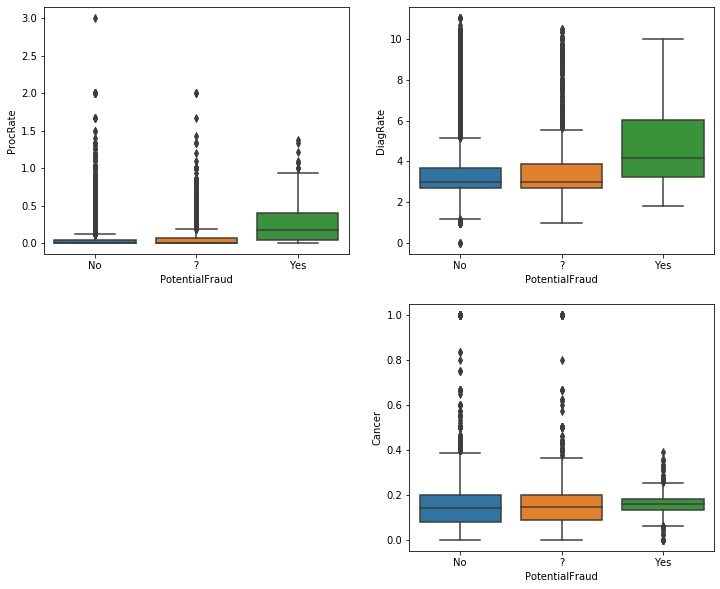

In [631]:
plt.figure(figsize=(12,10))
plt.subplot(221)
sns.boxplot(y = 'ProcRate', x = 'PotentialFraud', data = p)
plt.subplot(222)
sns.boxplot(y = 'DiagRate', x = 'PotentialFraud', data = p)
#plt.subplot(223)
#sns.boxplot(y = 'ChronicRate', x = 'PotentialFraud', data = p)
plt.subplot(224)
sns.boxplot(y = 'Cancer', x = 'PotentialFraud', data = p)

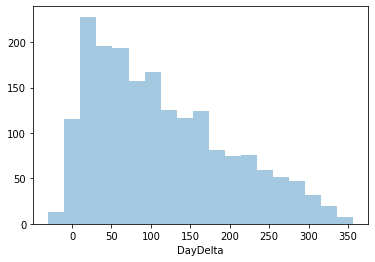

In [641]:
sns.distplot(a =claimTrack['DayDelta'], kde=False)


No     5258
Yes    3061
?      2086
Name: PotentialFraud, dtype: int64
206.44593945218645


,BeneID,ClaimID,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,DeductibleAmtPaid,Provider,PotentialFraud,State,TotalClaim
42,BENE11041,CLM497247,620,370,0.0,PRV55263,No,Florida,60.0
231,BENE11198,CLM190854,1930,1260,0.0,PRV55467,Yes,Ohio,1900.0
501,BENE11501,CLM354896,1840,770,0.0,PRV54882,Yes,Massachusetts,70.0
572,BENE11548,CLM160269,3460,740,0.0,PRV53269,Yes,Indiana,100.0
578,BENE11548,CLM677316,3460,740,0.0,PRV53269,Yes,Indiana,200.0
682,BENE11653,CLM733298,2360,450,0.0,PRV53524,No,Louisiana,200.0
717,BENE11672,CLM134470,4060,930,0.0,PRV52628,Yes,Illinois,20.0
770,BENE11715,CLM145450,130,220,0.0,PRV51574,Yes,California,80.0
785,BENE11732,CLM499994,960,150,0.0,PRV53266,Yes,Tennessee,500.0
799,BENE11758,CLM554041,4640,230,0.0,PRV53388,No,Louisiana,3300.0


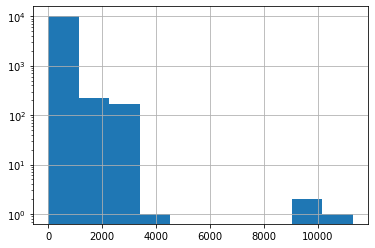

In [692]:
idx=outpat.index[outpat[['ClmAdmitDiagnosisCode','DiagnosisGroupCode','ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6']].isnull().all(1)]

nullRecords = outpat.loc[idx,['BeneID','ClaimID','OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt','DeductibleAmtPaid','Provider','PotentialFraud','State','TotalClaim']]
print(nullRecords['PotentialFraud'].value_counts())
ax = nullRecords['TotalClaim'].hist()
plt.yscale('log')

print(nullRecords['TotalClaim'].sum()/nullRecords.shape[0])
#ax2 = nullRecords.groupby(['State'])['ClaimID'].count().reset_index().sort_values('ClaimID').plot.bar()
nullRecords.head(20)

In [ ]:
firstProvider = dupRecords.sort_values('ClaimStartDt').groupby(['BeneID']).agg({'Provider': 'first',
                                                                'ClaimStartDt': 'first'})

df = dupRecords.merge(firstProvider, on=['BeneID','ClaimStartDt'], how = 'left')

df.fillna(0,inplace=True)
recipient = df.query('Provider_y==0')[['BeneID','ClaimStartDt','ClaimDays','TotalClaim','Provider_x','PotentialFraud']]
sender = df.query('Provider_x==Provider_y')[['BeneID','ClaimEndDt','ClaimDays','TotalClaim','Provider_x','PotentialFraud']]

claimTrack = pd.merge(sender,recipient,on='BeneID')

In [651]:
claimTrack[claimTrack.DayDelta < 0]['PotentialFraud_R'].value_counts()
claimTrack[claimTrack.DayDelta >300]['PotentialFraud_R'].value_counts()

No     32
Yes    12
?       7
Name: PotentialFraud_R, dtype: int64

In [605]:
data[['ClaimStartDt','ClaimEndDt']] = data[['ClaimStartDt','ClaimEndDt']].apply(pd.to_datetime)

In [611]:
data.groupby(['BeneID','Provider']).agg({'ClaimStartDt': time_interval})

KeyError: 'ClaimStartDt'

In [610]:
def time_interval(x):
    return pd.Series.to_frame(x['ClaimStartDt'] - x['ClaimStartDt'].shift(1))

In [609]:
time_interval

,ClaimStartDt
0,NaT
1,141 days
2,17 days
3,-215 days
4,-27 days
...,...
693598,12 days
693599,8 days
693600,40 days
693601,-115 days


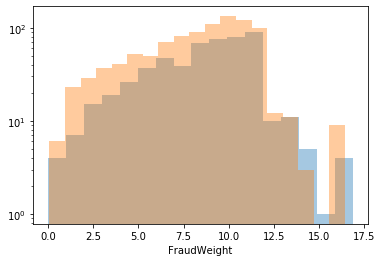

In [481]:
sns.distplot(a=claimTrack[claimTrack.PotentialFraud_R=='Yes']['FraudWeight'],kde=False)
plt.yscale('log')

sns.distplot(a=claimTrack[claimTrack.PotentialFraud_R=='No']['FraudWeight'],kde=False)
plt.yscale('log')

In [435]:
claimTrack.columns

Index(['BeneID', 'ClaimEndDt', 'ClaimDays_S', 'TotalClaim_S', 'Sender',
       'PotentialFraud_S', 'ClaimStartDt', 'ClaimDays_R', 'TotalClaim_R',
       'Receiver', 'PotentialFraud_R', 'ClaimMultiplier', 'TimeDelta',
       'DiffLengthOfStay', 'SimolClaim'],
      dtype='object')

In [652]:
for crimeType in quarter_crime.columns:
    
    fig = plt.subplots()
    plt.plot(rolledCrime[crimeType],'b-', label='rolling '+crimeType)
    plt.plot(quarter_crime[crimeType],'r--', label='quarterly '+crimeType)
    plt.xticks(x[::4]);
    plt.xticks(rotation=90)
    leg = plt.legend();

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,NumProc,NumDiag,AdmissionDays,ClaimDays,Age,TotalClaim,DailyCharge,InscCovPercent,DupRecord,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,0,10,7.0,7,66.0,27068.0,3866.857143,0.960544,0,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,4,3.0,3,67.0,6068.0,2022.666667,0.823995,0,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,0,7,4.0,4,67.0,6068.0,1517.000000,0.823995,0,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,10,9.0,9,95.0,6068.0,674.222222,0.823995,0,No
7,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,1,10,18.0,18,71.0,11068.0,614.888889,0.903506,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186030,BENE159139,CLM61015,2009-07-24,2009-07-26,PRV55021,23000,PHY406228,PHY406228,NaN,2009-07-24,...,2,10,3.0,3,69.0,24068.0,8022.666667,0.955626,0,?
186034,BENE159143,CLM42885,2009-03-16,2009-03-29,PRV55017,34000,PHY354080,NaN,NaN,2009-03-16,...,0,10,14.0,14,77.0,35068.0,2504.857143,0.969545,0,?
186037,BENE159155,CLM67124,2009-09-07,2009-10-12,PRV53758,5000,PHY338118,NaN,NaN,2009-09-07,...,0,11,36.0,36,76.0,6068.0,168.555556,0.823995,0,?
186038,BENE159181,CLM72016,2009-10-14,2009-10-17,PRV57195,3000,PHY328451,NaN,NaN,2009-10-14,...,0,10,4.0,4,73.0,4068.0,1017.000000,0.737463,0,?


In [79]:
data['TotalClaim'].sum()/1e6

743.451777

In [77]:
data[data.WhetherDead==1][['Provider','PotentialFraud','Age','DupRecord','TimeFromDeath','ClaimStartDt','DOD']].groupby(['Provider','PotentialFraud']).mean().reset_index().plot.b

,,Age,DupRecord,TimeFromDeath
Provider,PotentialFraud,,,
PRV51002,?,60.666667,0.0,127.333333
PRV51003,Yes,60.000000,0.0,230.000000
PRV51004,No,73.000000,0.0,100.000000
PRV51005,Yes,83.500000,0.0,74.250000
PRV51007,No,78.000000,0.0,74.000000
...,...,...,...,...
PRV57710,No,68.857143,0.0,150.857143
PRV57715,No,77.000000,0.0,161.666667
PRV57730,No,79.000000,0.0,230.000000


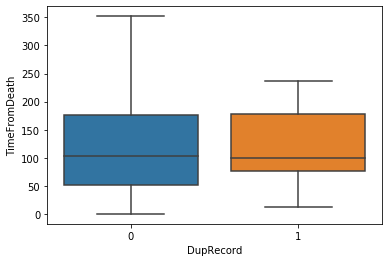

In [75]:
sns.boxplot(x = 'DupRecord',y = 'TimeFromDeath', data=df)

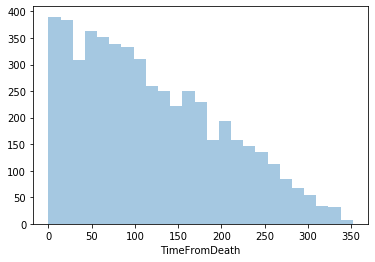

In [67]:
df = data[data.WhetherDead==1][['Provider','PotentialFraud','Age','DupRecord','TimeFromDeath']]
sns.distplot(a = df['TimeFromDeath'], kde=False)

In [70]:
df.query('DOD < ClaimStartDt')

UndefinedVariableError: name 'DOD' is not defined

In [65]:
data['TimeFromDeath'] = (data['DOD'] - data['ClaimStartDt']).dt.days

In [51]:
data[['DOD','ClaimStartDt','ClaimEndDt']] = data[['DOD','ClaimStartDt','ClaimEndDt']].apply(pd.to_datetime)

In [52]:
data['DOD']

0        NaT
1        NaT
2        NaT
3        NaT
4        NaT
          ..
693598   NaT
693599   NaT
693600   NaT
693601   NaT
693602   NaT
Name: DOD, Length: 693603, dtype: datetime64[ns]

In [427]:
claimTrack['SimolWeight'] = claimTrack['SimolClaim']*claimTrack['TimeDelta']*(-1)

In [428]:
claimTrack['DiffLOSWeight'] = claimTrack['']

,BeneID,ClaimEndDt,ClaimDays_S,TotalClaim_S,Sender,PotentialFraud_S,ClaimStartDt,ClaimDays_R,TotalClaim_R,Receiver,PotentialFraud_R,ClaimMultiplier,TimeDelta,DiffLengthOfStay,SimolClaim,SimolWeight
0,BENE11017,2009-02-16,1,10.0,PRV54761,No,2009-07-02,1,80.0,PRV54786,Yes,8.000000,136,0,0,0
1,BENE11548,2009-01-27,1,100.0,PRV53269,Yes,2009-11-12,1,200.0,PRV53269,Yes,2.000000,289,0,0,0
2,BENE12227,2009-09-25,1,40.0,PRV55935,No,2009-11-21,1,0.0,PRV53907,No,0.000000,57,0,0,0
3,BENE12394,2009-06-11,1,50.0,PRV52085,No,2009-11-11,1,10.0,PRV52985,Yes,0.200000,153,0,0,0
4,BENE12435,2009-04-16,1,100.0,PRV52120,Yes,2009-04-25,1,200.0,PRV52050,?,2.000000,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,BENE159124,2009-03-09,1,60.0,PRV52016,?,2009-03-31,1,10.0,PRV52120,Yes,0.166667,22,0,0,0
1882,BENE159124,2009-03-09,1,60.0,PRV52016,?,2009-05-22,1,50.0,PRV52120,Yes,0.833333,74,0,0,0
1883,BENE159124,2009-03-09,1,60.0,PRV52016,?,2009-08-24,1,60.0,PRV54966,Yes,1.000000,168,0,0,0
1884,BENE159128,2009-01-27,1,300.0,PRV53285,?,2009-04-17,1,1500.0,PRV53312,No,5.000000,80,0,0,0


In [ ]:
claimTrack['FraudWeight'] = 
claimTrack['SimolClaim']*claimTrack['TimeDelta']*(-1) +



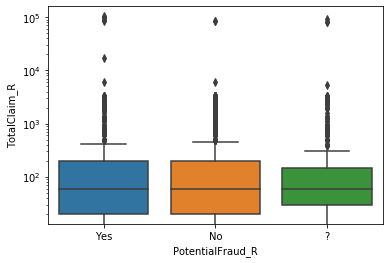

In [321]:
ax = sns.boxplot(x = 'PotentialFraud_R', y = 'TotalClaim_R', data=claimTrack)
plt.yscale('log')

It seems like they're duplicating their own records

- Assuming that the claimStartDates are authentic, identify the providers which are the information
receivers. Identify the providers which are the information givers.

In [340]:
dupRecords

,BeneID,ClaimID,TotalClaim,ClaimStartDt,Provider,PotentialFraud
12,BENE11017,CLM198169,10.0,2009-02-16,PRV54761,No
17,BENE11017,CLM448107,80.0,2009-07-02,PRV54786,Yes
111,BENE11093,CLM32146,21068.0,2009-01-03,PRV51842,Yes
112,BENE11093,CLM82202,21068.0,2009-01-03,PRV51842,Yes
572,BENE11548,CLM160269,100.0,2009-01-27,PRV53269,Yes
...,...,...,...,...,...,...
693249,BENE158773,CLM617710,800.0,2009-10-06,PRV52707,?
693317,BENE158874,CLM213758,20.0,2009-02-24,PRV55222,?
693530,BENE159124,CLM236816,60.0,2009-03-09,PRV52016,?
693533,BENE159128,CLM161175,300.0,2009-01-27,PRV53285,?


- Summarize the duplicate record counts/provider and study if the statistics have different
distributions between honest and potentialfraud providers.

In [337]:
df = dupRecords.groupby(['Provider','PotentialFraud'])['ClaimID'].count().reset_index()

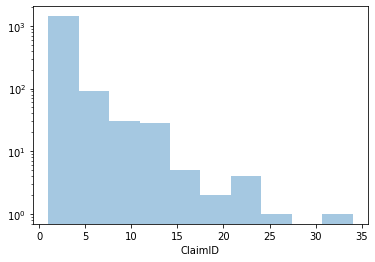

In [341]:
sns.distplot(a=df['ClaimID'], kde=False, bins=10)
plt.yscale('log')

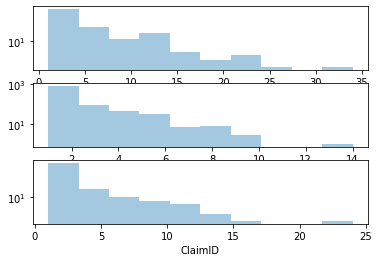

In [357]:
plt.subplots(2,1, sharex='row')

plt.subplot(311)
sns.distplot(a=df[df.PotentialFraud=='Yes']['ClaimID'], kde=False, bins=10)
plt.yscale('log')
plt.subplot(312)
sns.distplot(a=df[df.PotentialFraud=='No']['ClaimID'], kde=False, bins=10)
plt.yscale('log')

plt.subplot(313)
sns.distplot(a=df[df.PotentialFraud=='?']['ClaimID'], kde=False, bins=10)
plt.yscale('log')

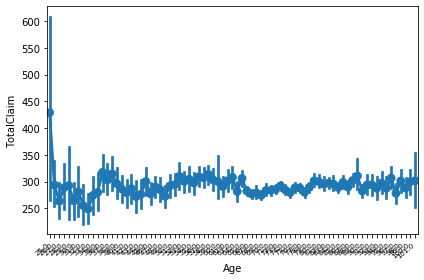

In [95]:
ax= sns.pointplot(x='Age',y='TotalClaim',data=outpat)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=7)
plt.tight_layout()

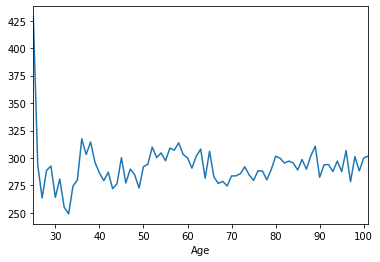

In [6]:
data.query('Status==\'out\'').groupby(['Age'])['TotalClaim'].mean().plot()

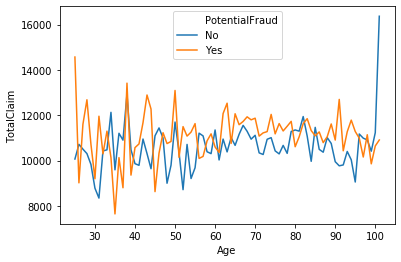

In [102]:
df = inpat[inpat.PotentialFraud !='?'].groupby(['Age','PotentialFraud'])['TotalClaim'].mean().reset_index()
sns.lineplot(x = 'Age', y = 'TotalClaim',hue='PotentialFraud', data = df)

- Do these potentially fraud providers reuse doctor IDs and/or patient IDs?  If so, these 
fradulent IDs (or if the doctors or patients willingly participate) can be used as signals to
the other types of fraudulent activities.

- Do these duplicated records show any anomaly in terms of geographic locations?
Even though the original data doesn't specify the providers nor the doctors' practice locations,
one may use the majority of the patients' residence state/county information to infer their
physical locations.

In [104]:
dup_features = ['BeneID','ClmDiagnosisCode_1', 'ClmDiagnosisCode_2','ClmDiagnosisCode_3']
idx = inpat.duplicated(subset=dup_features,keep=False)
print(inpat.loc[idx,dup_features].shape)
dup_records = inpat.loc[idx,['BeneID','State','County','Provider','PotentialFraud']]
dup_records

(42, 4)


,BeneID,State,County,Provider,PotentialFraud
111,BENE11093,Colorado,500,PRV51842,Yes
112,BENE11093,Colorado,500,PRV51842,Yes
15856,BENE24807,Minnesota,610,PRV54111,Yes
15858,BENE24807,Minnesota,610,PRV54111,Yes
31951,BENE39346,Minnesota,200,PRV54065,Yes
31952,BENE39346,Minnesota,200,PRV54065,Yes
37368,BENE44545,Kentucky,530,PRV52843,Yes
37369,BENE44545,Kentucky,530,PRV52843,Yes
40865,BENE47786,Indiana,290,PRV52828,Yes
40867,BENE47786,Indiana,290,PRV52828,Yes


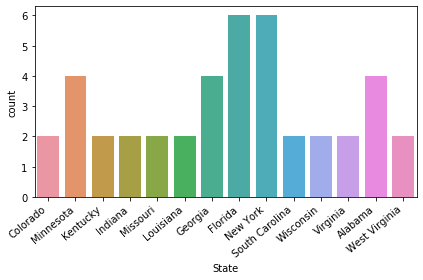

In [108]:
ax = sns.countplot(x = 'State', data = dup_records)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.tight_layout()

- Base on your best knowledge of suspicious activities in duplicating the patient claims, flag
the providers accordingly. Compare with the **PotentialFraud** flags offered by the dataset and discuss.